In [271]:
%matplotlib inline
%load_ext blackcellmagic
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, desc

The blackcellmagic extension is already loaded. To reload it, use:
  %reload_ext blackcellmagic


In [272]:
engine = create_engine("sqlite:///Data/hawaii.sqlite")
Base = automap_base()
Base.prepare(engine, reflect=True)
Base.classes.keys()

['measurement', 'station']

In [273]:
Measurement = Base.classes.measurement
Station = Base.classes.station
session = Session(engine)

---
## Precipitation Analysis
---

In [274]:
sql = """
        SELECT strftime('%m/%Y',date) as Month, SUM(prcp) AS Precipitation
        FROM measurement 
        WHERE date >= (SELECT MAX(date(date,'start of month','-11 months')) FROM measurement)
        GROUP BY Month
        Order BY date;
        """

precip = pd.read_sql(sql, con=engine, index_col="Month")
precip

,Precipitation
Month,
09/2016,49.40
10/2016,21.77
11/2016,20.56
12/2016,35.51
01/2017,11.95
02/2017,39.06
03/2017,29.62
04/2017,54.91
05/2017,25.27


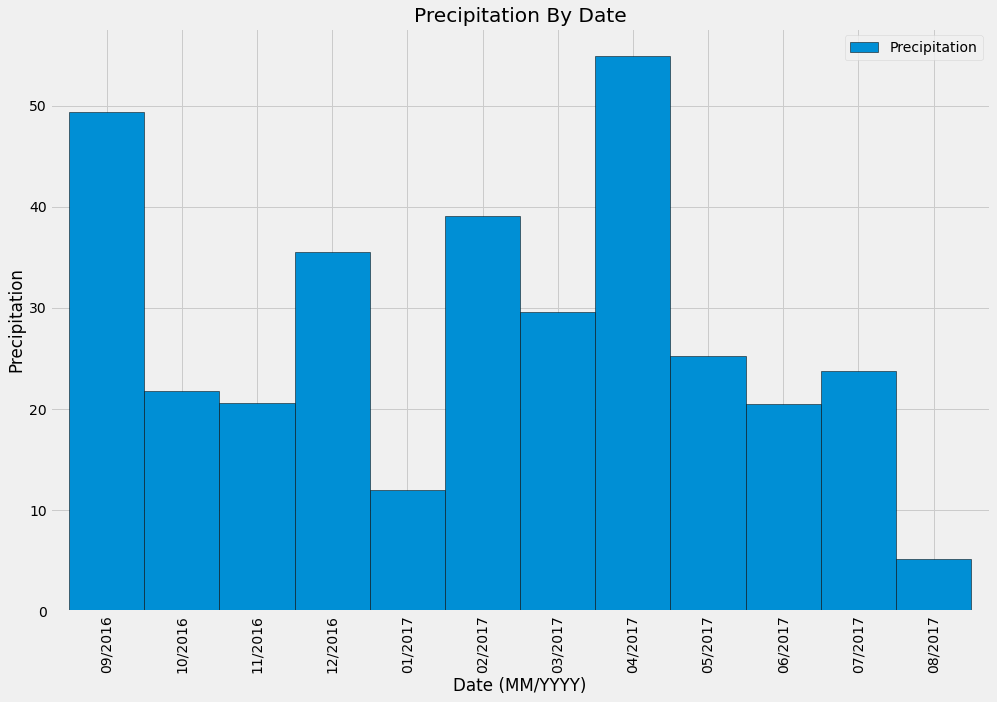

In [275]:
precipplt = precip.plot.bar(
    figsize=(15, 10), title="Precipitation By Date", width=1, edgecolor="k"
).set(xlabel="Date (MM/YYYY)", ylabel="Precipitation")
plt.show()

In [331]:
precip.describe()

,Precipitation
count,12.000000
mean,28.122500
std,14.514943
min,5.180000
25%,20.550000
50%,24.495000
75%,36.397500
max,54.910000


---
## Station Analysis
---

In [277]:
session.query(Station.station).distinct().count()

9

In [330]:
stations = (
    session.query(
        Measurement.station,
        Station.name,
        func.count(Measurement.date).label("Observations"),
    )
    .join(Station, Station.station == Measurement.station)
    .group_by(Measurement.station, Station.name)
    .order_by(desc("Observations"))
    .all()
)
stations

[('USC00519281', 'WAIHEE 837.5, HI US', 2772),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 2724),
 ('USC00513117', 'KANEOHE 838.1, HI US', 2709),
 ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 2669),
 ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 2612),
 ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 2202),
 ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 1979),
 ('USC00517948', 'PEARL CITY, HI US', 1372),
 ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 511)]

In [278]:
observations = (
    session.query(
        Measurement.station, func.count(Measurement.date).label("Observations")
    )
    .group_by(Measurement.station)
    .order_by(desc("Observations"))
    .all()
)
observations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

---
## Temprature Analysis
---

In [279]:
max_obs = max([observation.Observations for observation in observations])
session.query(
    Measurement.station, func.count(Measurement.date).label("Observations")
).group_by(Measurement.station).having(func.count(Measurement.date) == max_obs).all()

[('USC00519281', 2772)]

In [314]:
max_date = session.query(func.max(Measurement.date)).scalar()
temp_sql = (
    session.query(Measurement.date, Measurement.station, Measurement.tobs)
    .filter(Measurement.date > func.strftime("%Y-%m-%d", max_date, "-1 years"))
    .all()
)
temp_obs = pd.DataFrame(temp_sql)
temp_obs

,date,station,tobs
0,2016-08-24,USC00519397,79.0
1,2016-08-25,USC00519397,80.0
2,2016-08-26,USC00519397,79.0
3,2016-08-27,USC00519397,77.0
4,2016-08-28,USC00519397,78.0
...,...,...,...
2218,2017-08-19,USC00516128,71.0
2219,2017-08-20,USC00516128,78.0
2220,2017-08-21,USC00516128,76.0
2221,2017-08-22,USC00516128,76.0
